In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
from collections import OrderedDict, defaultdict
import os
import pprint

<IPython.core.display.Javascript object>

In [4]:
import datetime as dt
from dateutil.relativedelta import relativedelta

<IPython.core.display.Javascript object>

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import (
    create_engine,
    func,
    inspect,
    desc,
    MetaData,
    Table,
    Column,
    ForeignKey,
    Date,
    Integer,
    String,
    Float,
    distinct,
)

<IPython.core.display.Javascript object>

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

<IPython.core.display.Javascript object>

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

<IPython.core.display.Javascript object>

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

<IPython.core.display.Javascript object>

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

<IPython.core.display.Javascript object>

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

<IPython.core.display.Javascript object>

In [11]:
#Find the latest date in the db

session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23')

<IPython.core.display.Javascript object>

In [12]:
# Find the date from latest date to one year ago
year_ago = dt.date(2017, 8, 23) - relativedelta(years=1)
print(year_ago)

2016-08-23


<IPython.core.display.Javascript object>

In [13]:
# Extract 1 year of measurements

<IPython.core.display.Javascript object>

In [14]:
measurements_one_year = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= year_ago)
    .all()
)

<IPython.core.display.Javascript object>

In [15]:
# Create dataframe from one year of measurements using only prcp and date
prcp_df = pd.DataFrame.from_records(measurements_one_year)
prcp_df.columns = ["date", "prcp"]
prcp_df["date"] = pd.to_datetime(prcp_df.date, infer_datetime_format=True)
prcp_dict = prcp_df.set_index("date").to_dict()["prcp"]
prcp_df.columns = ["date", "precipitation"]
prcp_df.set_index("date", inplace=True)
# sort dataframe by date
prcp_df.sort_values(by="date")
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


<IPython.core.display.Javascript object>

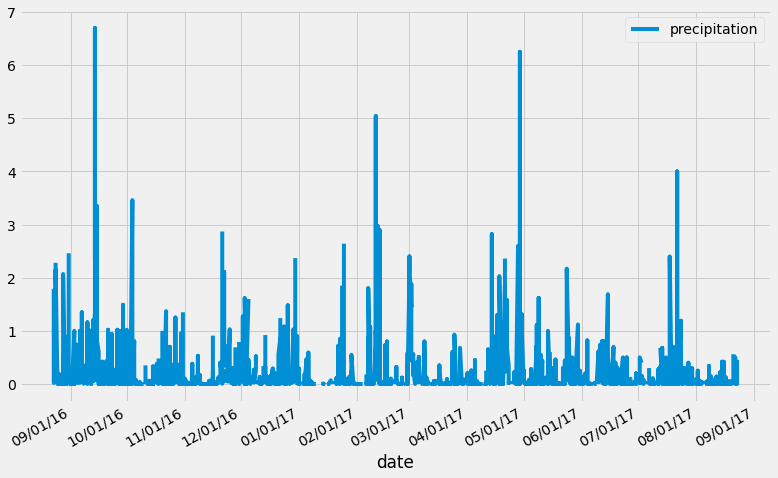

<IPython.core.display.Javascript object>

In [16]:
# Plot data using pandas
fig, ax = plt.subplots(figsize=(12, 8))
prcp_df.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

<IPython.core.display.Javascript object>

In [18]:
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


<IPython.core.display.Javascript object>

In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

<IPython.core.display.Javascript object>

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
(
    session.query(
        Measurement.station, func.count(Measurement.station).label("# counts")
    ).group_by(Measurement.station)
).order_by(desc("# counts")).first()

('USC00519281', 2772)

<IPython.core.display.Javascript object>

In [21]:
# List the stations and the counts in descending order.
(
    session.query(
        Measurement.station, func.count(Measurement.station).label("# counts")
    ).group_by(Measurement.station)
).order_by(desc("# counts")).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

<IPython.core.display.Javascript object>

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
session.query(
    Measurement.station,
    func.min(Measurement.tobs).label("t_min"),
    func.max(Measurement.tobs).label("t_max"),
    func.avg(Measurement.tobs).label("t_avg"),
).filter(Measurement.station == "USC00519281").all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>

In [23]:
# Choose the station with the highest number of temperature observations.
(
    session.query(
        Measurement.station, func.count(Measurement.tobs).label("#_t_counts")
    ).group_by(Measurement.station)
).order_by(desc("#_t_counts")).first()

('USC00519281', 2772)

<IPython.core.display.Javascript object>

In [24]:
# Determine last date entry for USC00519281
session.query(Measurement.date).filter(Measurement.station == "USC00519281").order_by(
    Measurement.date.desc()
).first()

('2017-08-18')

<IPython.core.display.Javascript object>

In [25]:
# Find the date from latest date to one year ago
year_ago = dt.date(2017, 8, 18) - relativedelta(years=1)
print(year_ago)

2016-08-18


<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018261915788>]],
      dtype=object)

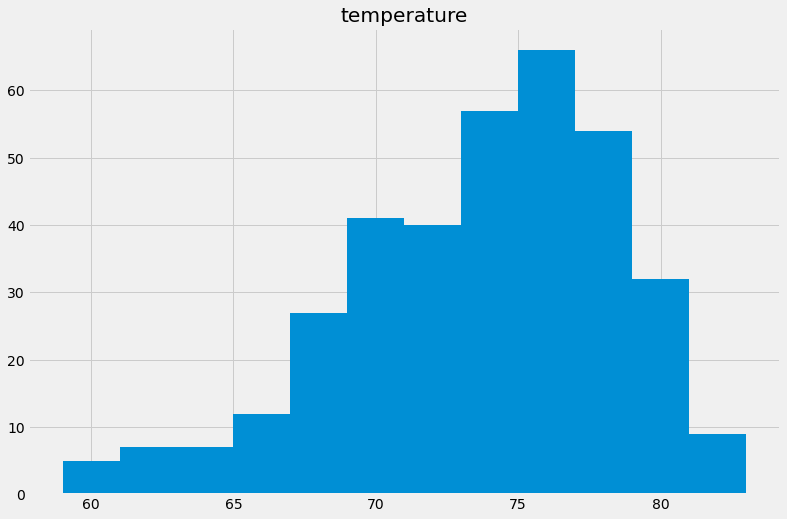

<IPython.core.display.Javascript object>

In [26]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == "USC00519281")
    .filter(Measurement.date >= year_ago)
    .all()
)
temp_df = pd.DataFrame.from_records(temp_obs)
temp_df.columns = ["date", "temperature"]
temp_df.set_index("date")

# Plot observations as histgram
temp_df.hist(column="temperature", figsize=(12, 8), bins=12)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


<IPython.core.display.Javascript object>

In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
# date of trip 2017-01-07 to 2017-08-07
trip_ts = calc_temps("2017-07-01", "2017-07-08")
print(trip_ts)

[(71.0, 78.04347826086956, 87.0)]


<IPython.core.display.Javascript object>

In [29]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_ts = trip_ts[0]
tmin = trip_ts[0]
tmax = trip_ts[2]
tavg = trip_ts[1]
yerr = tmax - tmin

<IPython.core.display.Javascript object>

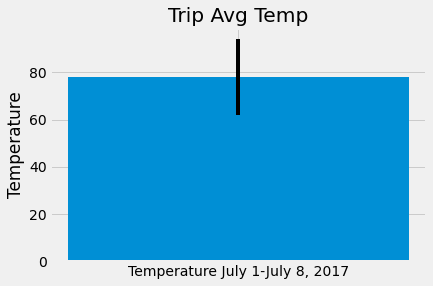

<IPython.core.display.Javascript object>

In [30]:
plt.bar(x="Temperature July 1-July 8, 2017", height=tavg, yerr=yerr)
plt.ylabel("Temperature")
plt.title("Trip Avg Temp")

plt.show()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

<IPython.core.display.Javascript object>

In [32]:
# Extract precip data fro trip
date_end = "2017-07-08"
date_start = "2017-07-01"
vacation_prcp = (
    session.query(Measurement.date, Measurement.prcp, Measurement.station)
    .filter(Measurement.date >= date_start)
    .filter(Measurement.date <= date_end)
    .all()
)
# Convert data to dataframe
vac_prcp_df = pd.DataFrame.from_records(vacation_prcp)
vac_prcp_df.columns = ["date", "precipitation", "station"]
vac_prcp_df["date"] = pd.to_datetime(vac_prcp_df.date, infer_datetime_format=True)
vac_prcp_df.head()

,date,precipitation,station
0,2017-07-01,0.02,USC00519397
1,2017-07-02,0.02,USC00519397
2,2017-07-03,0.04,USC00519397
3,2017-07-04,0.04,USC00519397
4,2017-07-05,0.00,USC00519397


<IPython.core.display.Javascript object>

In [33]:
# Read station data table as dataframe
station_df = pd.read_sql_table("station", con=engine)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


<IPython.core.display.Javascript object>

In [34]:
# Merge dataframes and sort data
df = pd.merge(station_df, vac_prcp_df, on="station")
df = df.sort_values(by="precipitation", ascending=False)
df.head()

,id,station,name,latitude,longitude,elevation,date,precipitation
39,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-07-02,0.50
40,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-07-03,0.40
44,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-07-07,0.30
36,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-07-07,0.18
31,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-07-02,0.15


<IPython.core.display.Javascript object>

## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

<IPython.core.display.Javascript object>

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


<IPython.core.display.Javascript object>

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>

In [38]:
# Plot the daily normals as an area plot with `stacked=False`

<IPython.core.display.Javascript object>